In [1]:
%load_ext autoreload
%autoreload 2
#---------- Library Imports ----------
import torch
import cv2
import numpy as np
from PIL import Image
from torchvision import transforms
import os
import sequential_creator
import glob
from torchmetrics import MeanAbsolutePercentageError as MAPE
import matplotlib as mpl
import re
import json
from tqdm import tqdm
import pytorch_lightning as pl
from torch.utils.data import DataLoader

c:\Users\Lasse\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%reload_ext autoreload

In [3]:
#---------- Personal python files imports ----------
import load_lettuce_dataset
import data_augmentation
import model_and_training_files
import lettuce_dataset

In [4]:
#---------- Hyperparameters ----------
batch_size = 16
learning_rate = 1e-3

In [5]:
#---------- Other parameters ----------
augmented_dataset_size = 341 # Size of the augmented dataset, so if the original dataset contained 103 images, they would be augmented and made into 2000 images
                              # One thing to note is that if this number is much bigger than the size of the original dataset, then they would most likely end up being duplicates, since there is not that many augmentations implemented at the moment

In [6]:
#---------- Load Lettuce Dataset ----------
rgb_list, depth_list, fresh_weight_list, dry_weight_list,height_list , diameter_list  = load_lettuce_dataset.load_all_images()

100%|██████████| 341/341 [00:04<00:00, 72.91it/s]


In [7]:
#---------- Augment Lettuce Dataset ----------
depth_img_aug, rgb_imgs_aug, fresh_weight_GT, dry_weight_GT, height_GT, diameter_GT = data_augmentation.augment_data(rgb_images=rgb_list, depth_images=depth_list, fresh_weight_GT=fresh_weight_list, dry_weight_GT=dry_weight_list,height_GT = height_list , diameter_GT = diameter_list , amount_of_augmentated_images=augmented_dataset_size)

Augmenting RGB Images


100%|██████████| 341/341 [00:56<00:00,  6.03it/s]


Amount of augmented images 341


In [8]:
#---------- Create data loaders ----------
# Concatenate the depth and rgb images
full_dataset = []
full_dataset_labels = []
for i in range(augmented_dataset_size):
    depth_plus_rgb = np.concatenate((depth_img_aug[i], rgb_imgs_aug[i]), axis=0)
    full_dataset.append(depth_plus_rgb)
    #full_dataset.append([depth_img_aug[i], rgb_imgs_aug[i]])
    #full_dataset_labels.append([fresh_weight_GT[i], dry_weight_GT[i]])
    #full_dataset_labels.append([dry_weight_GT[i]])
    full_dataset_labels.append([height_GT[i]])#, dry_weight_GT[i], height_GT[i], diameter_GT[i]])

print("Size of images in the dataset: ", np.array(full_dataset).shape, " --> (Amount of images, total channels, img_w, img_h)")
print("Size of images in the dataset: ", np.array(full_dataset[0][0]).shape)

# Define the dataset
dataset = lettuce_dataset.LettuceDataset(full_dataset, full_dataset_labels)

# Split the dataset in train, validation and test
splitted_data = lettuce_dataset.data_splittage(augmented_dataset_size, [75, 12.5, 12.5])
print("train, validation, test = ", splitted_data)

train_set, validation_set, test_set = torch.utils.data.random_split(dataset, splitted_data)
#train_set, validation_set, test_set = torch.utils.data.random_split(dataset, [7500, 1250, 1250])

# Create dataloaders for train, validation and test data
train_loader = DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True)
validation_loader = DataLoader(dataset = validation_set, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_set, batch_size = batch_size, shuffle = True)

Size of images in the dataset:  (341, 4, 640, 480)  --> (Amount of images, total channels, img_w, img_h)
Size of images in the dataset:  (640, 480)
train, validation, test =  [255, 42, 44]


In [9]:
#---------- Model Definition ----------
# Code modified from Anders Glent Buch elective course Deep Neural Networks
# Tip: dont forget to include activation layer (ReLu)

def build_cnn_layer(in_channels, out_channels, kernal_size=3, stride=1, padding=1, 
                    use_batchnorm=True, pool=False):
    '''
    in_channels: input channels to 2d convolution layer
    out_channels: ouput channels to 2d convolution layer
    kernal_size: kernal size (refer torch conv2d)
    stride: stride (refer torch conv2d)
    padding: padding (refer torch conv2d)  
    use_batchnorm: enable/disable batchnorm (refer torch BatchNorm2d)
    pool: enable/disable pooling (refer torch MaxPool2D)

    should return the built CNN layer
    '''
    return torch.nn.Sequential(
        torch.nn.Conv2d(in_channels, out_channels, kernal_size, stride=stride, padding=padding),
        #print((torch.nn.Conv2d(in_channels, out_channels, kernal_size, stride=stride, padding=padding).shape())),
        torch.nn.ReLU(inplace=True),
        torch.nn.BatchNorm2d(out_channels) if use_batchnorm else torch.nn.Identity(),
        torch.nn.MaxPool2d(3, 3) if pool else torch.nn.Identity(),
    )

# Remember to flatten after convolution layers before its passed to linear layers
# Also activation layer for final layers
def build_cnn_model():
    '''
    pool: enable/disable pooling

    should return built CNN model
    '''
    return torch.nn.Sequential(
        # (B, 4, 640, 480) images
        build_cnn_layer(4, 8, stride=1, pool=True),
        build_cnn_layer(8, 16, stride=1, pool=True), 
        build_cnn_layer(16, 32, stride=1, pool=True),
        build_cnn_layer(32, 32, stride=1, pool=True),
        build_cnn_layer(32, 32, stride=1, pool=True),
        torch.nn.Flatten(),
        torch.nn.Linear(64 , 32),
        torch.nn.ReLU(True),
        torch.nn.Linear(32, 16),
        torch.nn.ReLU(True),
        torch.nn.Linear(16, 16),
        #torch.nn.BatchNorm1d(16), # (B, 512)
        torch.nn.Linear(16, 1), # (B, 2) logits
    )    
    

In [10]:
#---------- Model declaration ----------
cnnmodel = build_cnn_model()

In [11]:
print(cnnmodel)

Sequential(
  (0): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [12]:
#---------- Training ----------
print("Cuda available = ", torch.cuda.is_available())

# Define the model with Pytorch Lightning
model = model_and_training_files.BiomassModel(CNNmodel=cnnmodel,lr=learning_rate, )

trainer = model_and_training_files.get_trainer()    # gets the trainer (which is a class that takes the model and dataset)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=validation_loader) # Train the model
trainer.test(model, dataloaders=test_loader)

#---

Cuda available =  True


Auto select gpus: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | model     | Sequential | 27.7 K
1 | loss_func | HuberLoss  | 0     
-----------------------------------------
27.7 K    Trainable params
0         Non-trainable params
27.7 K    Total params
0.111     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\Lasse\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
c:\Users\Lasse\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


c:\Users\Lasse\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\Lasse\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\trainer.py:1555: PossibleUserWarning: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 14: 100%|██████████| 19/19 [00:42<00:00,  2.24s/it, loss=1.48, v_num=58]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


c:\Users\Lasse\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
c:\Users\Lasse\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    2.2617387771606445     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.2617387771606445}]

In [13]:
#------- Save the weights ----------
#print(model. )

torch.save(model.model, "saved_models/height.plk") # Saves the regression head

In [14]:
cnnmodel = torch.load("saved_models/height.plk")
modelcnn = model_and_training_files.BiomassModel(CNNmodel=cnnmodel, lr=learning_rate,)
#fresh_weight_GT, dry_weight_GT
imgidx = 234
#print(full_dataset[imgidx].shape)
#print(torch.tensor(full_dataset[imgidx]).float().shape)
model.eval()
pred = model.prediction(torch.tensor(np.array(dataset.data[imgidx])).float())
print(pred)
print(full_dataset_labels[imgidx])

modelcnn.eval()
pred = modelcnn.prediction(torch.tensor(np.array(dataset.data[imgidx])).float())
print(pred)
print(full_dataset_labels[imgidx])

tensor([[37.0491]])
[34.0]
tensor([[37.0491]])
[34.0]


height  mean =  2.008084362203425
height  std =  1.9329264562703183
height  var =  3.7362046853497306
height  NRMSE =  0.11770591877606618
(44,)
(44,)


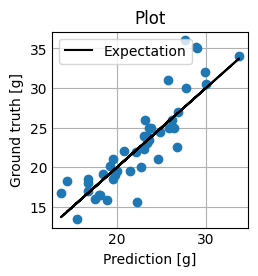

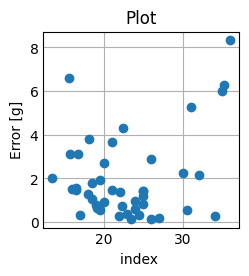

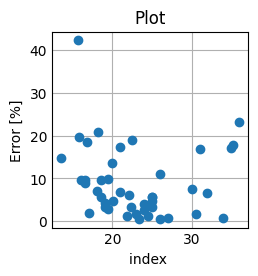

In [25]:
from plotdataset import plot_dataset, plot_full_dataset
#print(len(test_loader.dataset[0][0]))
plot_full_dataset(modelcnn, test_loader)